In [1]:
import pandas as pd
import numpy as np
import json
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
import seaborn as sns

pd.set_option('display.max_columns', None)

In [2]:
shot_metrics_df = pd.read_csv("shot_metric_df.csv")

In [3]:
#good_shooters = shot_metrics_df[["player_id","statsbomb_xg"]].groupby("player_id",as_index=False).count().sort_values(by="statsbomb_xg", ascending=False)
#good_shooters = good_shooters[good_shooters["statsbomb_xg"]>99]
#shot_metrics_df =  shot_metrics_df[shot_metrics_df["player_id"].isin(good_shooters.player_id)]

In [4]:
shot_metrics_df["over_xg"] = shot_metrics_df["goal"]  - shot_metrics_df["statsbomb_xg"] 

In [5]:
shot_metrics_df["age"]= (pd.to_datetime(shot_metrics_df["match_date"])-pd.to_datetime(shot_metrics_df["birth_date"]))/pd.Timedelta(days=365.25)
shot_metrics_df["age"]= shot_metrics_df["age"].astype(int)

<Axes: ylabel='Density'>

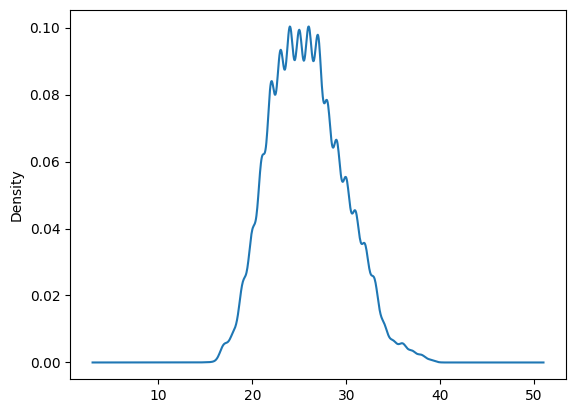

In [6]:
shot_metrics_df["age"].plot.density()

In [7]:

variable_list = [
    "High Intensity (HI) Distance_now", "High Intensity (HI) Distance_half", "High Intensity (HI) Distance_game", 
    "High Speed Running (HSR) Distance_now", "High Speed Running (HSR) Distance_half", "High Speed Running (HSR) Distance_game", 
    "Running Distance_now", "Running Distance_half", "Running Distance_game", 
    "Sprinting Distance_now", "Sprinting Distance_half", "Sprinting Distance_game", 
    "Total Distance_now", "Total Distance_half", "Total Distance_game", 
    "Count HI_1_week", "Count HSR_1_week", "Count High Acceleration_1_week", "Count High Deceleration_1_week", 
    "Count Medium Acceleration_1_week", "Count Medium Deceleration_1_week", "Count Sprint_1_week", 
    "High Intensity (HI) Distance_1_week", "High Speed Running (HSR) Distance_1_week", "M/min_1_week", 
    "Max Speed_1_week", "Running Distance_1_week", "Sprinting Distance_1_week", "Total Distance_1_week", 
    "Count HI_2_week", "Count HSR_2_week", "Count High Acceleration_2_week", "Count High Deceleration_2_week", 
    "Count Medium Acceleration_2_week", "Count Medium Deceleration_2_week", "Count Sprint_2_week", 
    "High Intensity (HI) Distance_2_week", "High Speed Running (HSR) Distance_2_week", "M/min_2_week", 
    "Max Speed_2_week", "Running Distance_2_week", "Sprinting Distance_2_week", "Total Distance_2_week", 
    "Count HI_1_month", "Count HSR_1_month", "Count High Acceleration_1_month", "Count High Deceleration_1_month", 
    "Count Medium Acceleration_1_month", "Count Medium Deceleration_1_month", "Count Sprint_1_month", 
    "High Intensity (HI) Distance_1_month", "High Speed Running (HSR) Distance_1_month", "M/min_1_month", 
    "Max Speed_1_month", "Running Distance_1_month", "Sprinting Distance_1_month", "Total Distance_1_month"
]


In [8]:
#clean df for ML use
shot_metrics_df =shot_metrics_df[shot_metrics_df.penalty==0]
shot_metrics_df = shot_metrics_df.fillna(0)
shot_metrics_df.under_pressure = np.where(shot_metrics_df.under_pressure==True,1,0)


In [9]:
#leave spanish clubs out
#clubs to leave out of training

test_clubs = [
    "Athletic Club",
    "Getafe",
    "Real Betis",
    "Girona",
  "Las Palmas",
    "Sevilla",
    "Celta Vigo",
   "Deportivo Alavés",
     "Osasuna",
     "Barcelona",
    "Valencia",
     "Rayo Vallecano",
    "Real Sociedad",
     "Real Madrid",
     "Mallorca",
    "Villarreal",
    "Atlético Madrid"
    ]

In [10]:
shot_metrics_df.head(1)

Unnamed: 0                              event_id  event_index  period  \
0           0  24392d1d-314a-4063-a729-7775bc0a2c45        130.0     1.0   

      timestamp  minute  second  possession  duration  obv_for_after  \
0  00:03:04.524     3.0     4.0         9.0  0.471596       0.306241   

   obv_for_before  obv_for_net  obv_against_after  obv_against_before  \
0        0.278243     0.027997           0.007197            0.007197   

   obv_against_net  obv_total_net  under_pressure  type_id type_name  \
0              0.0       0.027997               1     16.0      Shot   

   possession_team_id possession_team_name  play_pattern_id play_pattern_name  \
0                36.0      Manchester City              2.0       From Corner   

   team_id        team_name  location_x  location_y  location_z  \
0     36.0  Manchester City       112.7        39.9        0.22   

                                      related_events  player_id  \
0  67dc6041-d315-4ebb-ac8e-18f3fcd24abc, 7d4f2f91...    23616.0   

     player_name  position_id   position_name  statsbomb_xg  goal  penalty  \
0  Erling Håland         23.0  Center Forward      0.166126   1.0      0.0   

   body_part  opposition_in_triangle   gameId  match_date  Count HI_now  \
0  Left Foot                     1.0  3892755  2023-08-11           1.2   

   Count HI_half  Count HI_game  Count HSR_now  Count HSR_half  \
0            0.0            0.0            1.0             0.0   

   Count HSR_game  Count High Acceleration_now  Count High Acceleration_half  \
0             0.0                          0.2                           0.0   

   Count High Acceleration_game  Count High Deceleration_now  \
0                           0.0                          0.4   

   Count High Deceleration_half  Count High Deceleration_game  \
0                           0.0                           0.0   

   Count Medium Acceleration_now  Count Medium Acceleration_half  \
0                            6.8                             0.0   

   Count Medium Acceleration_game  Count Medium Deceleration_now  \
0                             0.0                            4.4   

   Count Medium Deceleration_half  Count Medium Deceleration_game  \
0                             0.0                             0.0   

   Count Sprint_now  Count Sprint_half  Count Sprint_game  \
0               0.2                0.0                0.0   

   High Intensity (HI) Distance_now  High Intensity (HI) Distance_half  \
0                         17.017352                                0.0   

   High Intensity (HI) Distance_game  High Speed Running (HSR) Distance_now  \
0                                0.0                              15.196193   

   High Speed Running (HSR) Distance_half  \
0                                     0.0   

   High Speed Running (HSR) Distance_game  M/min_now  M/min_half  M/min_game  \
0                                     0.0  20.433466         0.0         0.0   

   Max Speed_now  Max Speed_half  Max Speed_game  Running Distance_now  \
0       5.187833             0.0             0.0             37.352316   

   Running Distance_half  Running Distance_game  Sprinting Distance_now  \
0                    0.0                    0.0                1.821159   

   Sprinting Distance_half  Sprinting Distance_game  Total Distance_now  \
0                      0.0                      0.0          306.501986   

   Total Distance_half  Total Distance_game  Count HI_1_week  \
0                  0.0                  0.0             48.0   

   Count HSR_1_week  Count High Acceleration_1_week  \
0              30.0                            30.0   

   Count High Deceleration_1_week  Count Medium Acceleration_1_week  \
0                            25.0                             141.0   

   Count Medium Deceleration_1_week  Count Sprint_1_week  \
0                             110.0                 18.0   

   High Intensity (HI) Distance_1_week  \
0                        

In [11]:
ML_data= shot_metrics_df[["team_name","goal", "position_name","under_pressure","play_pattern_name","body_part" ,"location_x","location_y","location_z","opposition_in_triangle"]]
play_pattern_onehot = pd.get_dummies(ML_data.play_pattern_name, 
    prefix="play_pattern")#, dtype=float)
body_part_onehot = pd.get_dummies(ML_data.body_part, 
    prefix="pbody_part")#, dtype=float)
position_name_onehot = pd.get_dummies(ML_data.position_name, 
    prefix="position_name")#, dtype=float)
ML_data = pd.concat([ML_data,play_pattern_onehot,body_part_onehot,position_name_onehot], axis=1).drop(["play_pattern_name","body_part","position_name"],axis=1)
training_data =  ML_data[~ML_data.team_name.isin(test_clubs)].drop("team_name",axis=1)
test_data =  ML_data[ML_data.team_name.isin(test_clubs)].drop("team_name",axis=1)

In [12]:
X_train_raw = training_data.drop("goal", axis=1).astype(float)
y_train_raw = training_data["goal"].astype(int)

X_test = np.array(test_data.drop("goal", axis=1).astype(float))
y_test = np.array(test_data["goal"].astype(int))

#scaler = StandardScaler()
#model = scaler.fit(X_train_raw)
#X_scaled = model.transform(X_train_raw)
#X_test = model.transform(X_test_raw)
X_train, X_val, y_train, y_val = train_test_split(
    np.array(X_train_raw), np.array(y_train_raw), test_size=0.25, random_state=123
)

In [13]:

# Define features and target
neg, pos = np.bincount(y_train)
scale = neg / pos
print(f"scale_pos_weight = {scale:.2f}")


# Initialize XGBoost classifier
model = xgb.XGBClassifier(
    n_estimators=1000,       # number of trees
    max_depth=5,           # depth of each tree
    learning_rate=0.05,     # step size shrinkage
    subsample=0.8,        # row sampling
    colsample_bytree=0.8,  # feature sampling
    random_state=42,
    use_label_encoder=False,
    objective="binary:logistic",#logitraw
    eval_metric="logloss",
    #scale_pos_weight=4  # avoids warning about label encoder
)

# Train model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]

# Evaluation
acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {acc:.3f}")
print(f"ROC AUC: {roc:.3f}")

scale_pos_weight = 8.43


c:\Users\conny\OneDrive\Documents\Projects\Hudl_Performance\Hudl_Performance_Insights_2025\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:00:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.904
ROC AUC: 0.763


In [14]:
statsbomb_test = np.where(shot_metrics_df[shot_metrics_df.team_name.isin(test_clubs)].statsbomb_xg>0.5,1,0)
statsbomb_actual = np.array(shot_metrics_df[shot_metrics_df.team_name.isin(test_clubs)].goal)
statsbomb_proba = np.array(shot_metrics_df[shot_metrics_df.team_name.isin(test_clubs)].statsbomb_xg)

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[8175,   86],
       [ 800,  130]])

In [16]:
confusion_matrix(statsbomb_actual,statsbomb_test )

array([[8206,   55],
       [ 794,  136]])

In [17]:
acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {acc:.3f}")
print(f"ROC AUC: {roc:.3f}")

Accuracy: 0.904
ROC AUC: 0.763


In [18]:
acc = accuracy_score(statsbomb_actual,statsbomb_test )
roc = roc_auc_score(statsbomb_actual, statsbomb_proba)

print(f"Accuracy: {acc:.3f}")
print(f"ROC AUC: {roc:.3f}")

Accuracy: 0.908
ROC AUC: 0.793


In [19]:
training_data.columns

Index(['goal', 'under_pressure', 'location_x', 'location_y', 'location_z',
       'opposition_in_triangle', 'play_pattern_From Corner',
       'play_pattern_From Counter', 'play_pattern_From Free Kick',
       'play_pattern_From Goal Kick', 'play_pattern_From Keeper',
       'play_pattern_From Kick Off', 'play_pattern_From Throw In',
       'play_pattern_Other', 'play_pattern_Regular Play', 'pbody_part_Head',
       'pbody_part_Left Foot', 'pbody_part_Other', 'pbody_part_Right Foot',
       'position_name_Center Attacking Midfield', 'position_name_Center Back',
       'position_name_Center Defensive Midfield',
       'position_name_Center Forward', 'position_name_Goalkeeper',
       'position_name_Left Attacking Midfield', 'position_name_Left Back',
       'position_name_Left Center Back', 'position_name_Left Center Forward',
       'position_name_Left Center Midfield',
       'position_name_Left Defensive Midfield', 'position_name_Left Midfield',
       'position_name_Left Wing', 'pos

autogluon roc_auc 15 minutes
Accuracy: 0.906
ROC AUC: 0.777

In [20]:
importance = model.get_booster().get_score(importance_type="weight")
print(importance)

{'f0': 644.0, 'f1': 6338.0, 'f2': 6442.0, 'f3': 3071.0, 'f4': 1491.0, 'f5': 379.0, 'f6': 216.0, 'f7': 378.0, 'f8': 188.0, 'f9': 132.0, 'f10': 80.0, 'f11': 451.0, 'f12': 47.0, 'f13': 471.0, 'f14': 111.0, 'f15': 507.0, 'f16': 43.0, 'f17': 299.0, 'f18': 198.0, 'f19': 89.0, 'f20': 141.0, 'f21': 336.0, 'f23': 101.0, 'f24': 105.0, 'f25': 162.0, 'f26': 207.0, 'f27': 158.0, 'f28': 139.0, 'f29': 124.0, 'f30': 215.0, 'f31': 119.0, 'f32': 132.0, 'f33': 119.0, 'f34': 161.0, 'f35': 177.0, 'f36': 111.0, 'f37': 158.0, 'f38': 112.0, 'f39': 258.0, 'f40': 137.0}


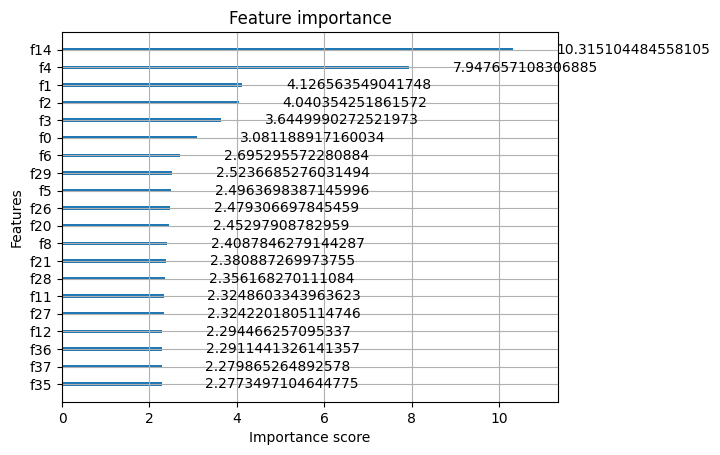

In [21]:
xgb.plot_importance(model, importance_type="gain", max_num_features=20)
plt.show()

In [22]:
importance_df = pd.DataFrame.from_dict(
    model.get_booster().get_score(importance_type="gain"),
    orient="index",
    columns=["importance"]
).sort_values("importance", ascending=False)

print(importance_df.head(10))

     importance
f14   10.315104
f4     7.947657
f1     4.126564
f2     4.040354
f3     3.644999
f0     3.081189
f6     2.695296
f29    2.523669
f5     2.496370
f26    2.479307


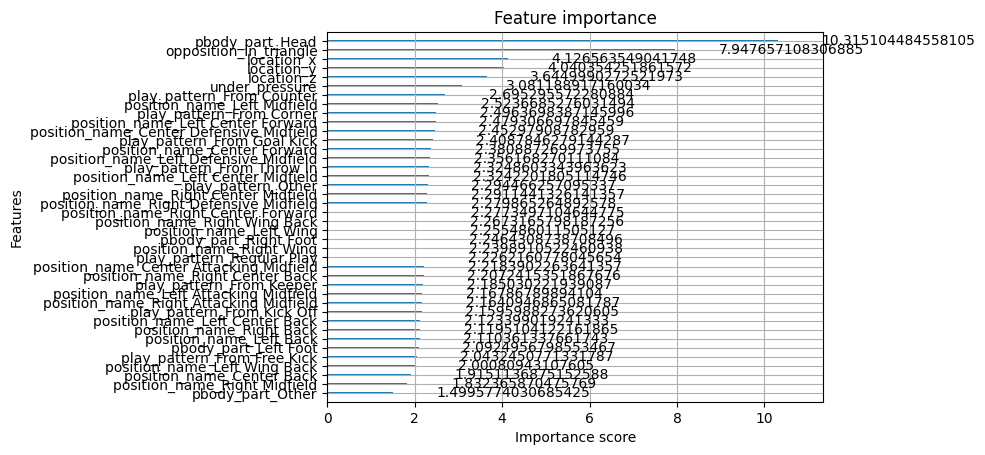

In [23]:
booster = model.get_booster()
booster.feature_names = X_train_raw.columns.tolist()

xgb.plot_importance(booster, importance_type="gain")
plt.show()


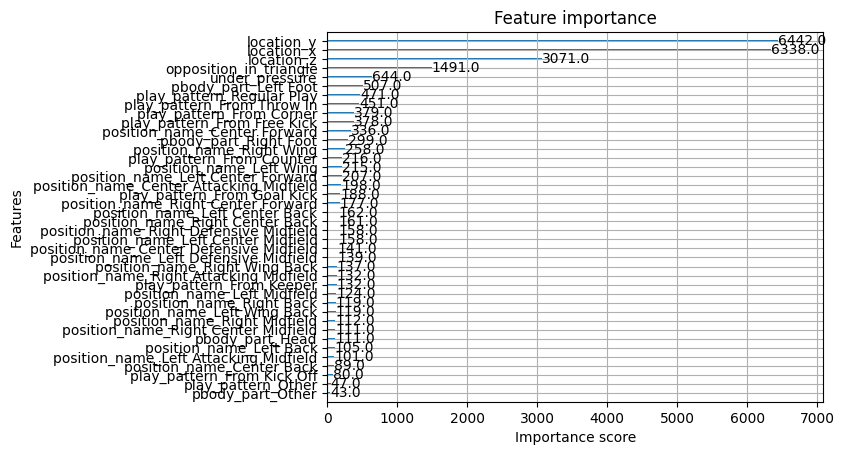

In [24]:
booster = model.get_booster()
booster.feature_names = X_train_raw.columns.tolist()

xgb.plot_importance(booster, importance_type="weight")
plt.show()


add physical metrics

In [25]:
shot_metrics_df.columns[shot_metrics_df.columns.str.contains("Distance")]

Index(['High Intensity (HI) Distance_now', 'High Intensity (HI) Distance_half',
       'High Intensity (HI) Distance_game',
       'High Speed Running (HSR) Distance_now',
       'High Speed Running (HSR) Distance_half',
       'High Speed Running (HSR) Distance_game', 'Running Distance_now',
       'Running Distance_half', 'Running Distance_game',
       'Sprinting Distance_now', 'Sprinting Distance_half',
       'Sprinting Distance_game', 'Total Distance_now', 'Total Distance_half',
       'Total Distance_game', 'High Intensity (HI) Distance_1_week',
       'High Speed Running (HSR) Distance_1_week', 'Running Distance_1_week',
       'Sprinting Distance_1_week', 'Total Distance_1_week',
       'High Intensity (HI) Distance_2_week',
       'High Speed Running (HSR) Distance_2_week', 'Running Distance_2_week',
       'Sprinting Distance_2_week', 'Total Distance_2_week',
       'High Intensity (HI) Distance_1_month',
       'High Speed Running (HSR) Distance_1_month', 'Running Distance_

In [26]:
shot_metrics_df.head()

Unnamed: 0                              event_id  event_index  period  \
0           0  24392d1d-314a-4063-a729-7775bc0a2c45        130.0     1.0   
1           1  3c527d7b-6932-4190-8424-d1d3dcdd6a4d        191.0     1.0   
2           2  157da96f-2535-42f1-aaa4-273dc8ae2f12        368.0     1.0   
3           3  6a0404a3-2dd6-44d2-8c70-15bb2f858b82        535.0     1.0   
4           4  c06abd5a-b096-47eb-8352-6a5470db6d83        629.0     1.0   

      timestamp  minute  second  possession  duration  obv_for_after  \
0  00:03:04.524     3.0     4.0         9.0  0.471596       0.306241   
1  00:05:11.529     5.0    11.0        11.0  1.023995       0.000000   
2  00:10:51.930    10.0    51.0        21.0  0.363535       0.000000   
3  00:14:17.334    14.0    17.0        27.0  1.067938       0.000000   
4  00:17:42.690    17.0    42.0        30.0  0.687717       0.047946   

   obv_for_before  obv_for_net  obv_against_after  obv_against_before  \
0        0.278243     0.027997           0.007197            0.007197   
1        0.034124    -0.034124           0.009421            0.009421   
2        0.204285    -0.204285           0.006885            0.006885   
3        0.095475    -0.095475           0.008562            0.008562   
4        0.076592    -0.028646           0.008465            0.008465   

   obv_against_net  obv_total_net  under_pressure  type_id type_name  \
0              0.0       0.027997               1     16.0      Shot   
1              0.0      -0.034124               0     16.0      Shot   
2              0.0      -0.204285               0     16.0      Shot   
3              0.0      -0.095475               0     16.0      Shot   
4              0.0      -0.028646               0     16.0      Shot   

   possession_team_id possession_team_name  play_pattern_id play_pattern_name  \
0                36.0      Manchester City              2.0       From Corner   
1                36.0      Manchester City              7.0    From Goal Kick   
2                36.0      Manchester City              3.0    From Free Kick   
3                34.0              Burnley              4.0     From Throw In   
4                34.0              Burnley              3.0    From Free Kick   

   team_id        team_name  location_x  location_y  location_z  \
0     36.0  Manchester City       112.7        39.9        0.22   
1     36.0  Manchester City        88.4        46.0        0.00   
2     36.0  Manchester City       114.7        46.6        1.08   
3     34.0          Burnley       104.7        31.0        0.00   
4     34.0          Burnley       107.2        26.6        0.00   

                                      related_events  player_id  \
0  67dc6041-d315-4ebb-ac8e-18f3fcd24abc, 7d4f2f91...    23616.0   
1               207b5c5a-ff48-4534-a5e2-0f83b20df80a     3089.0   
2               764d5d53-f1a1-4d37-9f78-b549101782c5    23616.0   
3               200cd1f9-50d7-4e73-9143-106f764722f8   256682.0   
4               8ebcd607-df4e-495e-8062-9cbf005d4fdf    48335.0   

            player_name  position_id          position_name  statsbomb_xg  \
0         Erling Håland         23.0         Center Forward      0.166126   
1       Kevin De Bruyne         13.0  Right Center Midfield      0.023693   
2         Erling Håland         23.0         Center Forward      0.142146   
3         Luca Koleosho         17.0             Right Wing      0.083945   
4  Mohamed Zeki Amdouni         23.0         Center Forward      0.085442   

   goal  penalty   body_part  opposition_in_triangle   gameId  match_date  \
0   1.0      0.0   Left Foot                     1.0  3892755  2023-08-11   
1   0.0      0.0  Right Foot                     2.0  3892755  2023-08-11   
2   0.0      0.0  Right Foot                     1.0  3892755  2023-08-11   
3   0.0      0.0  Right Foot                     1.0  3892755  2023-08-11   
4   0.0      0.0   Left Foot                     1.0  3892755  2023-08-11   

   Count HI_now  Count

In [27]:
def workload_index(df, period):
    # Extract the relevant columns for the period
    metrics = [
        df[f"Count High Deceleration_{period}"],
        df[f"Count High Acceleration_{period}"],
        df[f"High Speed Running (HSR) Distance_{period}"],
        df[f"Sprinting Distance_{period}"]
    ]
    
    # Stack all metrics to compute overall min and max
    all_metrics = pd.concat(metrics, axis=0)
    
    # Normalize each metric between 0 and 1
    normalized_metrics = []
    for metric in metrics:
        normalized = (metric - all_metrics.min()) / (all_metrics.max() - all_metrics.min())
        normalized_metrics.append(normalized)
    
    # Sum the normalized metrics (equal weighting)
    return sum(normalized_metrics)


# Example: compute workload index for different periods
for period in ["now", "half", "game", "1_week", "2_week", "1_month"]:
    shot_metrics_df[f"WI_{period}"] = workload_index(shot_metrics_df, period)

# Compute ACWR (Acute:Chronic Workload Ratio)
shot_metrics_df["ACWR"] = shot_metrics_df["WI_1_week"] / (shot_metrics_df["WI_1_month"]/4)
shot_metrics_df["ACWR"] = np.where(shot_metrics_df["ACWR"].isna(), 0,shot_metrics_df["ACWR"])
#shot_metrics_df["ACWR"] = np.where(shot_metrics_df["ACWR"]>0.9, shot_metrics_df["ACWR"]*0.8,shot_metrics_df["ACWR"])
shot_metrics_df["ACWR_bucket"] = pd.cut(
    shot_metrics_df["ACWR"],
    bins=[-float('inf'), 0.01, 2.3, float('inf')], #bins=[-float('inf'), 0.01, 1, float('inf')],# bins=[-float('inf'), 0.8, 1.3, 2, float('inf')],
    labels=["No Fatigue", "Low/Medium Fatigue", "High Fatigue"]#, "Q4"
)
shot_metrics_df["ACWR_pos"] = np.where(shot_metrics_df["ACWR"]<0.8, 1,0)

In [28]:
shot_metrics_df = shot_metrics_df[(shot_metrics_df.WI_1_month!=0)]

In [29]:
shot_metrics_df.head()

Unnamed: 0                              event_id  event_index  period  \
0           0  24392d1d-314a-4063-a729-7775bc0a2c45        130.0     1.0   
1           1  3c527d7b-6932-4190-8424-d1d3dcdd6a4d        191.0     1.0   
2           2  157da96f-2535-42f1-aaa4-273dc8ae2f12        368.0     1.0   
3           3  6a0404a3-2dd6-44d2-8c70-15bb2f858b82        535.0     1.0   
4           4  c06abd5a-b096-47eb-8352-6a5470db6d83        629.0     1.0   

      timestamp  minute  second  possession  duration  obv_for_after  \
0  00:03:04.524     3.0     4.0         9.0  0.471596       0.306241   
1  00:05:11.529     5.0    11.0        11.0  1.023995       0.000000   
2  00:10:51.930    10.0    51.0        21.0  0.363535       0.000000   
3  00:14:17.334    14.0    17.0        27.0  1.067938       0.000000   
4  00:17:42.690    17.0    42.0        30.0  0.687717       0.047946   

   obv_for_before  obv_for_net  obv_against_after  obv_against_before  \
0        0.278243     0.027997           0.007197            0.007197   
1        0.034124    -0.034124           0.009421            0.009421   
2        0.204285    -0.204285           0.006885            0.006885   
3        0.095475    -0.095475           0.008562            0.008562   
4        0.076592    -0.028646           0.008465            0.008465   

   obv_against_net  obv_total_net  under_pressure  type_id type_name  \
0              0.0       0.027997               1     16.0      Shot   
1              0.0      -0.034124               0     16.0      Shot   
2              0.0      -0.204285               0     16.0      Shot   
3              0.0      -0.095475               0     16.0      Shot   
4              0.0      -0.028646               0     16.0      Shot   

   possession_team_id possession_team_name  play_pattern_id play_pattern_name  \
0                36.0      Manchester City              2.0       From Corner   
1                36.0      Manchester City              7.0    From Goal Kick   
2                36.0      Manchester City              3.0    From Free Kick   
3                34.0              Burnley              4.0     From Throw In   
4                34.0              Burnley              3.0    From Free Kick   

   team_id        team_name  location_x  location_y  location_z  \
0     36.0  Manchester City       112.7        39.9        0.22   
1     36.0  Manchester City        88.4        46.0        0.00   
2     36.0  Manchester City       114.7        46.6        1.08   
3     34.0          Burnley       104.7        31.0        0.00   
4     34.0          Burnley       107.2        26.6        0.00   

                                      related_events  player_id  \
0  67dc6041-d315-4ebb-ac8e-18f3fcd24abc, 7d4f2f91...    23616.0   
1               207b5c5a-ff48-4534-a5e2-0f83b20df80a     3089.0   
2               764d5d53-f1a1-4d37-9f78-b549101782c5    23616.0   
3               200cd1f9-50d7-4e73-9143-106f764722f8   256682.0   
4               8ebcd607-df4e-495e-8062-9cbf005d4fdf    48335.0   

            player_name  position_id          position_name  statsbomb_xg  \
0         Erling Håland         23.0         Center Forward      0.166126   
1       Kevin De Bruyne         13.0  Right Center Midfield      0.023693   
2         Erling Håland         23.0         Center Forward      0.142146   
3         Luca Koleosho         17.0             Right Wing      0.083945   
4  Mohamed Zeki Amdouni         23.0         Center Forward      0.085442   

   goal  penalty   body_part  opposition_in_triangle   gameId  match_date  \
0   1.0      0.0   Left Foot                     1.0  3892755  2023-08-11   
1   0.0      0.0  Right Foot                     2.0  3892755  2023-08-11   
2   0.0      0.0  Right Foot                     1.0  3892755  2023-08-11   
3   0.0      0.0  Right Foot                     1.0  3892755  2023-08-11   
4   0.0      0.0   Left Foot                     1.0  3892755  2023-08-11   

   Count HI_now  Count

In [30]:
shot_metrics_df["ACWR"].mean()

np.float64(3.29760456832341)

<Axes: ylabel='Density'>

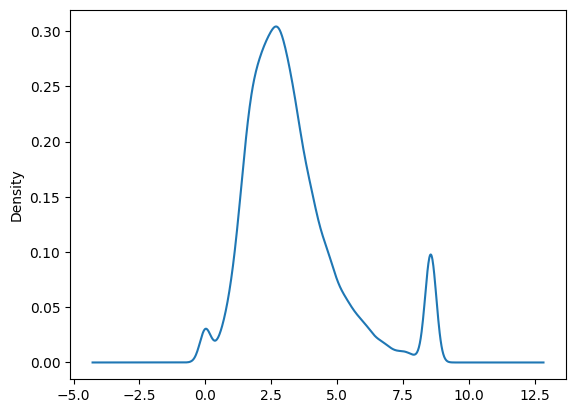

In [31]:
shot_metrics_df["ACWR"].plot.density()

In [32]:
len(shot_metrics_df[shot_metrics_df["ACWR"]==0])

746

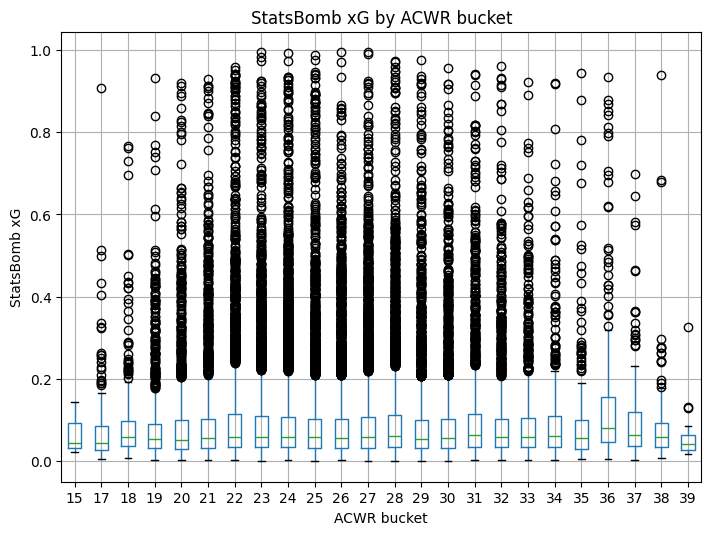

In [33]:
import plotly.express as px
df = shot_metrics_df.copy()
fig, ax = plt.subplots(figsize=(8, 6))
df.boxplot(column="statsbomb_xg", by="age", ax=ax)

# Beautify
ax.set_title("StatsBomb xG by ACWR bucket")
ax.set_xlabel("ACWR bucket")
ax.set_ylabel("StatsBomb xG")
plt.suptitle("")  # remove automatic "Boxplot grouped by..." title
plt.show()

In [34]:
ML_data= shot_metrics_df[[
    "age","team_name","goal", "under_pressure","play_pattern_name","body_part" ,"location_x","location_y","location_z","opposition_in_triangle",
    'ACWR_bucket',
    'WI_now', 'WI_game', 'WI_1_week','WI_2_week','WI_1_month',
       'ACWR',
        'ACWR_pos',
    #"position_name",
    "Count HI_1_week", "Count HSR_1_week", "Count High Acceleration_1_week", "Count High Deceleration_1_week", 
    "Count Medium Acceleration_1_week", "Count Medium Deceleration_1_week", "Count Sprint_1_week", 
    "High Intensity (HI) Distance_1_week", "High Speed Running (HSR) Distance_1_week", "M/min_1_week", 
    "Max Speed_1_week", "Running Distance_1_week", "Sprinting Distance_1_week", "Total Distance_1_week", 
    "Count HI_2_week", "Count HSR_2_week", "Count High Acceleration_2_week", "Count High Deceleration_2_week", 
    "Count Medium Acceleration_2_week", "Count Medium Deceleration_2_week", "Count Sprint_2_week", 
    "High Intensity (HI) Distance_2_week", "High Speed Running (HSR) Distance_2_week", "M/min_2_week", 
    "Max Speed_2_week", "Running Distance_2_week", "Sprinting Distance_2_week", "Total Distance_2_week", 
    "Count HI_1_month", "Count HSR_1_month", "Count High Acceleration_1_month", "Count High Deceleration_1_month", 
    "Count Medium Acceleration_1_month", "Count Medium Deceleration_1_month", "Count Sprint_1_month", 
    "High Intensity (HI) Distance_1_month", "High Speed Running (HSR) Distance_1_month", "M/min_1_month", 
    "Max Speed_1_month", "Running Distance_1_month", "Sprinting Distance_1_month", "Total Distance_1_month"
]]
play_pattern_onehot = pd.get_dummies(ML_data.play_pattern_name, 
    prefix="play_pattern")#, dtype=float)
body_part_onehot = pd.get_dummies(ML_data.body_part, 
    prefix="pbody_part")#, dtype=float)
#position_name_onehot = pd.get_dummies(ML_data.position_name, 
#    prefix="position_name")#, dtype=float)
acwr_onehot = pd.get_dummies(ML_data.ACWR_bucket, 
    prefix="acwr")#, dtype=float)
ML_data = pd.concat([ML_data,play_pattern_onehot,body_part_onehot,acwr_onehot ], axis=1).drop(["play_pattern_name","body_part",'ACWR_bucket'],axis=1)
training_data =  ML_data[~ML_data.team_name.isin(test_clubs)].drop("team_name",axis=1)
test_data =  ML_data[ML_data.team_name.isin(test_clubs)].drop("team_name",axis=1)

just players with over 100 shots?

In [35]:
X_train_raw = training_data.drop("goal", axis=1).astype(float)
y_train_raw = training_data["goal"].astype(int)

X_test = np.array(test_data.drop("goal", axis=1).astype(float))
y_test = np.array(test_data["goal"].astype(int))

#scaler = StandardScaler()
#model = scaler.fit(X_train_raw)
#X_scaled = model.transform(X_train_raw)
#X_test = model.transform(X_test_raw)
X_train, X_val, y_train, y_val = train_test_split(
    np.array(X_train_raw), np.array(y_train_raw), test_size=0.25, random_state=123
)

In [36]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score


# Define features and target
neg, pos = np.bincount(y_train)
scale = neg / pos
print(f"scale_pos_weight = {scale:.2f}")


# Initialize XGBoost classifier
model = xgb.XGBClassifier(
    n_estimators=1000,       # number of trees
    max_depth=5,           # depth of each tree
    learning_rate=0.05,     # step size shrinkage
    subsample=0.8,        # row sampling
    colsample_bytree=0.8,  # feature sampling
    random_state=42,
    use_label_encoder=False,
    objective="binary:logistic",
    eval_metric="logloss",
    #scale_pos_weight=4  # avoids warning about label encoder
)

# Train model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]

# Evaluation
acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {acc:.3f}")
print(f"ROC AUC: {roc:.3f}")

scale_pos_weight = 8.51


c:\Users\conny\OneDrive\Documents\Projects\Hudl_Performance\Hudl_Performance_Insights_2025\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:00:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.904
ROC AUC: 0.749


In [37]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[8171,   69],
       [ 809,  119]])

In [38]:
confusion_matrix(statsbomb_actual,statsbomb_test )

array([[8206,   55],
       [ 794,  136]])

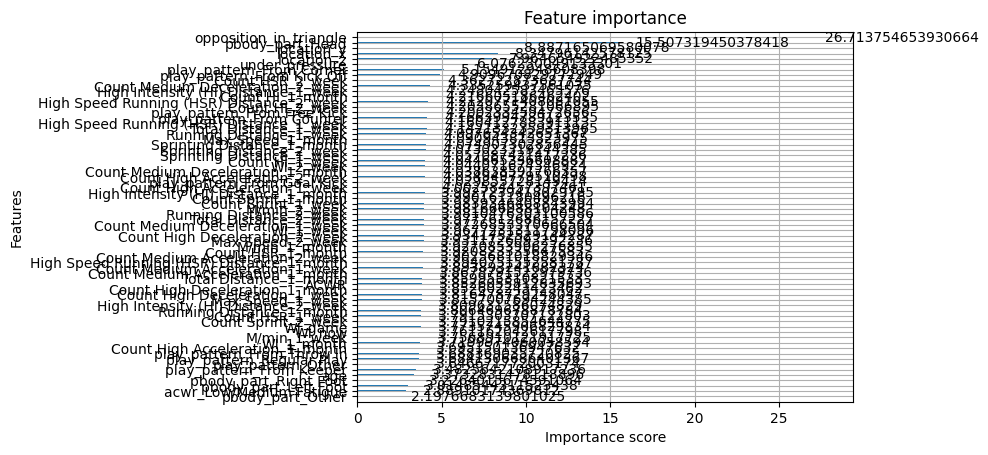

In [39]:
booster = model.get_booster()
booster.feature_names = X_train_raw.columns.tolist()

xgb.plot_importance(booster, importance_type="gain")
plt.show()

In [40]:
importance_df = pd.DataFrame.from_dict(
    model.get_booster().get_score(importance_type="gain"),
    orient="index",
    columns=["importance"]
).sort_values("importance", ascending=False)

print(importance_df.head(30))

                                          importance
opposition_in_triangle                     26.713755
pbody_part_Head                            15.507319
location_y                                  8.887165
location_x                                  8.347961
location_z                                  7.964655
under_pressure                              6.076230
play_pattern_From Corner                    5.154913
play_pattern_From Kick Off                  4.909671
Count HSR_2_week                            4.362723
Count Medium Deceleration_2_week            4.335259
High Intensity (HI) Distance_1_week         4.248043
Count HI_1_month                            4.216605
High Speed Running (HSR) Distance_2_week    4.212077
Count HI_2_week                             4.203866
play_pattern_From Free Kick                 4.200233
play_pattern_From Counter                   4.166399
High Speed Running (HSR) Distance_1_week    4.160413
Total Distance_1_week                       4.

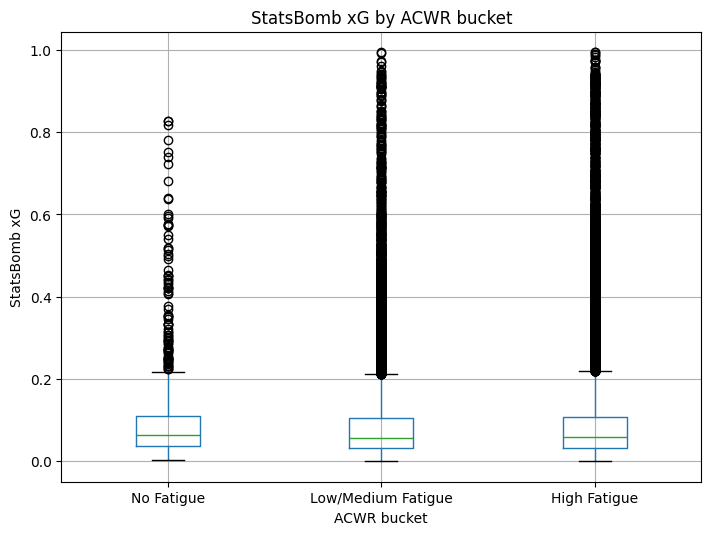

In [41]:
import plotly.express as px
df = shot_metrics_df.copy()
fig, ax = plt.subplots(figsize=(8, 6))
df.boxplot(column="statsbomb_xg", by="ACWR_bucket", ax=ax)

# Beautify
ax.set_title("StatsBomb xG by ACWR bucket")
ax.set_xlabel("ACWR bucket")
ax.set_ylabel("StatsBomb xG")
plt.suptitle("")  # remove automatic "Boxplot grouped by..." title
plt.show()

if not better explanation maybe different shots?

does match by match tiredness reduce shot number (quality) in next game? avg xg per shot?

match_date player avg_shot_xg (max ).str.endswith(('1_week', '2_week', '1_month')

In [42]:
shot_metrics_df.head(1)

Unnamed: 0                              event_id  event_index  period  \
0           0  24392d1d-314a-4063-a729-7775bc0a2c45        130.0     1.0   

      timestamp  minute  second  possession  duration  obv_for_after  \
0  00:03:04.524     3.0     4.0         9.0  0.471596       0.306241   

   obv_for_before  obv_for_net  obv_against_after  obv_against_before  \
0        0.278243     0.027997           0.007197            0.007197   

   obv_against_net  obv_total_net  under_pressure  type_id type_name  \
0              0.0       0.027997               1     16.0      Shot   

   possession_team_id possession_team_name  play_pattern_id play_pattern_name  \
0                36.0      Manchester City              2.0       From Corner   

   team_id        team_name  location_x  location_y  location_z  \
0     36.0  Manchester City       112.7        39.9        0.22   

                                      related_events  player_id  \
0  67dc6041-d315-4ebb-ac8e-18f3fcd24abc, 7d4f2f91...    23616.0   

     player_name  position_id   position_name  statsbomb_xg  goal  penalty  \
0  Erling Håland         23.0  Center Forward      0.166126   1.0      0.0   

   body_part  opposition_in_triangle   gameId  match_date  Count HI_now  \
0  Left Foot                     1.0  3892755  2023-08-11           1.2   

   Count HI_half  Count HI_game  Count HSR_now  Count HSR_half  \
0            0.0            0.0            1.0             0.0   

   Count HSR_game  Count High Acceleration_now  Count High Acceleration_half  \
0             0.0                          0.2                           0.0   

   Count High Acceleration_game  Count High Deceleration_now  \
0                           0.0                          0.4   

   Count High Deceleration_half  Count High Deceleration_game  \
0                           0.0                           0.0   

   Count Medium Acceleration_now  Count Medium Acceleration_half  \
0                            6.8                             0.0   

   Count Medium Acceleration_game  Count Medium Deceleration_now  \
0                             0.0                            4.4   

   Count Medium Deceleration_half  Count Medium Deceleration_game  \
0                             0.0                             0.0   

   Count Sprint_now  Count Sprint_half  Count Sprint_game  \
0               0.2                0.0                0.0   

   High Intensity (HI) Distance_now  High Intensity (HI) Distance_half  \
0                         17.017352                                0.0   

   High Intensity (HI) Distance_game  High Speed Running (HSR) Distance_now  \
0                                0.0                              15.196193   

   High Speed Running (HSR) Distance_half  \
0                                     0.0   

   High Speed Running (HSR) Distance_game  M/min_now  M/min_half  M/min_game  \
0                                     0.0  20.433466         0.0         0.0   

   Max Speed_now  Max Speed_half  Max Speed_game  Running Distance_now  \
0       5.187833             0.0             0.0             37.352316   

   Running Distance_half  Running Distance_game  Sprinting Distance_now  \
0                    0.0                    0.0                1.821159   

   Sprinting Distance_half  Sprinting Distance_game  Total Distance_now  \
0                      0.0                      0.0          306.501986   

   Total Distance_half  Total Distance_game  Count HI_1_week  \
0                  0.0                  0.0             48.0   

   Count HSR_1_week  Count High Acceleration_1_week  \
0              30.0                            30.0   

   Count High Deceleration_1_week  Count Medium Acceleration_1_week  \
0                            25.0                             141.0   

   Count Medium Deceleration_1_week  Count Sprint_1_week  \
0                             110.0                 18.0   

   High Intensity (HI) Distance_1_week  \
0                        

In [43]:
pattern_cols = shot_metrics_df.filter(regex='_(1_week|2_week|1_month)$').columns
#pattern_cols = shot_metrics_df.filter(regex='ACWR').columns
specific_cols = ["player_id", "match_date", "over_xg","ACWR","ACWR_pos","ACWR_bucket"]#statsbomb_xg


In [44]:
shot_metrics_df[specific_cols + list(pattern_cols)]

player_id  match_date   over_xg      ACWR  ACWR_pos  \
0        23616.0  2023-08-11  0.833874  8.557780         0   
1         3089.0  2023-08-11 -0.023693  8.557780         0   
2        23616.0  2023-08-11 -0.142146  8.557780         0   
3       256682.0  2023-08-11 -0.083945  8.557780         0   
4        48335.0  2023-08-11 -0.085442  8.557780         0   
...          ...         ...       ...       ...       ...   
61649    33281.0  2025-05-21 -0.052227  8.557780         0   
61650     3336.0  2025-05-21 -0.032896  3.401081         0   
61651   151931.0  2025-05-21 -0.024010  1.591516         0   
61652     3382.0  2025-05-21 -0.093079  3.540773         0   
61653     5539.0  2025-05-21 -0.039709  4.061995         0   

              ACWR_bucket  Count HI_1_week  Count HSR_1_week  \
0            High Fatigue        48.000000         30.000000   
1            High Fatigue        18.000000         17.000000   
2            High Fatigue        48.000000         30.000000   
3            High Fatigue        55.000000         46.000000   
4            High Fatigue        46.000000         37.000000   
...                   ...              ...               ...   
61649        High Fatigue        13.567539          9.161843   
61650        High Fatigue        78.356195         55.777684   
61651  Low/Medium Fatigue        44.643605         32.878553   
61652        High Fatigue        85.699673         60.868366   
61653        High Fatigue        93.800777         71.216352   

       Count High Acceleration_1_week  Count High Deceleration_1_week  \
0                           30.000000                       25.000000   
1                            3.000000                        6.000000   
2                           30.000000                       25.000000   
3                           27.000000                       43.000000   
4                           15.000000                       20.000000   
...                               ...                             ...   
61649                        5.607248                        7.609837   
61650                       43.623669                       54.234031   
61651                       23.848080                       27.218608   
61652                       40.888930                       47.432148   
61653                       41.193435                       36.192847   

       Count Medium Acceleration_1_week  Count Medium Deceleration_1_week  \
0                            141.000000                        110.000000   
1                             51.000000                         41.000000   
2                            141.000000                        110.000000   
3                            179.000000                        141.000000   
4                            162.000000                        129.000000   
...                                 ...                               ...   
61649                         45.346119                         34.870076   
61650                        331.715859                        269.190750   
61651                        181.118216                        151.292218   
61652                        314.551703                        254.020803   
61653                        346.103203                        309.106048   

       Count Sprint_1_week  High Intensity (HI) Distance_1_week  \
0                18.000000                           836.038147   
1                 1.000000                           171.572998   
2                18.000000                           836.038147   
3                 9.000000                           639.982910   
4                 9.000000                           531.848816   
...                    ...                                  ...   
61649             4.405695                           217.099068   
61650            22.578512                          1145.525804   
61651            11.765053                           605.789979   
61652            24.8

In [45]:
shots_by_player_match = shot_metrics_df[specific_cols + list(pattern_cols)]#.groupby(["player_id","match_date"],as_index=False).min()

In [46]:
#shots_by_player_match = shot_metrics_df[["player_id", "match_date", "statsbomb_xg","ACWR","ACWR_pos","ACWR_bucket"]]

In [47]:
shots_by_player_match.columns

Index(['player_id', 'match_date', 'over_xg', 'ACWR', 'ACWR_pos', 'ACWR_bucket',
       'Count HI_1_week', 'Count HSR_1_week', 'Count High Acceleration_1_week',
       'Count High Deceleration_1_week', 'Count Medium Acceleration_1_week',
       'Count Medium Deceleration_1_week', 'Count Sprint_1_week',
       'High Intensity (HI) Distance_1_week',
       'High Speed Running (HSR) Distance_1_week', 'M/min_1_week',
       'Max Speed_1_week', 'Running Distance_1_week',
       'Sprinting Distance_1_week', 'Total Distance_1_week', 'Count HI_2_week',
       'Count HSR_2_week', 'Count High Acceleration_2_week',
       'Count High Deceleration_2_week', 'Count Medium Acceleration_2_week',
       'Count Medium Deceleration_2_week', 'Count Sprint_2_week',
       'High Intensity (HI) Distance_2_week',
       'High Speed Running (HSR) Distance_2_week', 'M/min_2_week',
       'Max Speed_2_week', 'Running Distance_2_week',
       'Sprinting Distance_2_week', 'Total Distance_2_week',
       'Count HI_1

In [48]:
group_col = ["player_id","match_date"]#
mean_col = "over_xg"#'statsbomb_xg'

other_cols = [col for col in shots_by_player_match.columns if col not in group_col]

agg_dict = {mean_col: ['mean', 'sum', 'count']}
agg_dict.update({col: 'max' for col in other_cols if col != mean_col})

shots_by_player_match = shots_by_player_match.groupby(group_col, as_index=False).agg(agg_dict)

# Flatten column names
shots_by_player_match.columns = [f"{col[0]}_{col[1]}" if col[1] != '' else col[0] 
                                for col in shots_by_player_match.columns]



In [49]:
#shot_metrics_df[(shot_metrics_df.player_id==106904.0) |(shot_metrics_df.player_id==199774.0)].to_csv("what.csv")

Maybe take just strikers with over 30 shots or 100 or whatever

In [50]:
good_shooters = shot_metrics_df[["player_id","statsbomb_xg"]].groupby("player_id",as_index=False).count().sort_values(by="statsbomb_xg", ascending=False)
good_shooters = good_shooters[good_shooters["statsbomb_xg"]>1]
shots_by_player_match_good =  shots_by_player_match[shots_by_player_match["player_id"].isin(good_shooters.player_id)]
good_shooters

player_id  statsbomb_xg
554     10955.0           292
94       3531.0           258
786     23616.0           256
1107    39461.0           234
1269    52129.0           228
...         ...           ...
1531   321252.0             2
1555   386729.0             2
1546   358512.0             2
1559   396287.0             2
1542   348525.0             2

[1524 rows x 2 columns]

In [51]:
#shot_metrics_df.to_csv("lessee.csv")

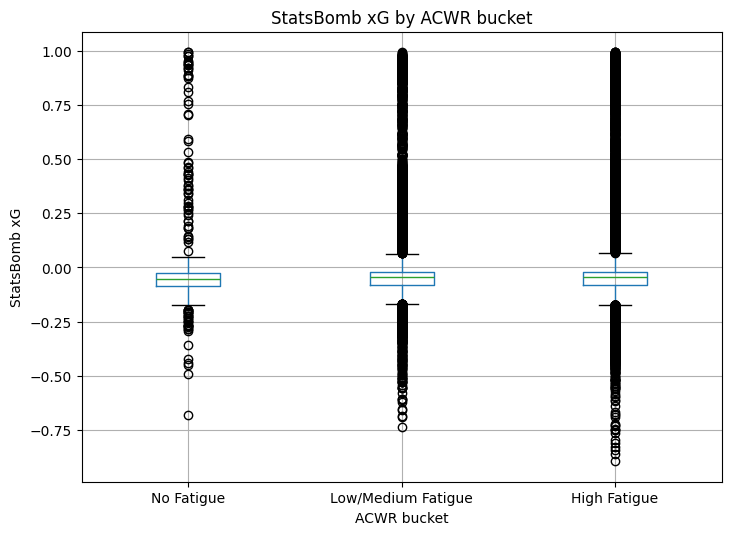

In [52]:
import plotly.express as px
df = shots_by_player_match.copy()
fig, ax = plt.subplots(figsize=(8, 6))
df.boxplot(column="over_xg_mean", by="ACWR_bucket_max", ax=ax)

# Beautify
ax.set_title("StatsBomb xG by ACWR bucket")
ax.set_xlabel("ACWR bucket")
ax.set_ylabel("StatsBomb xG")
plt.suptitle("")  # remove automatic "Boxplot grouped by..." title
plt.show()

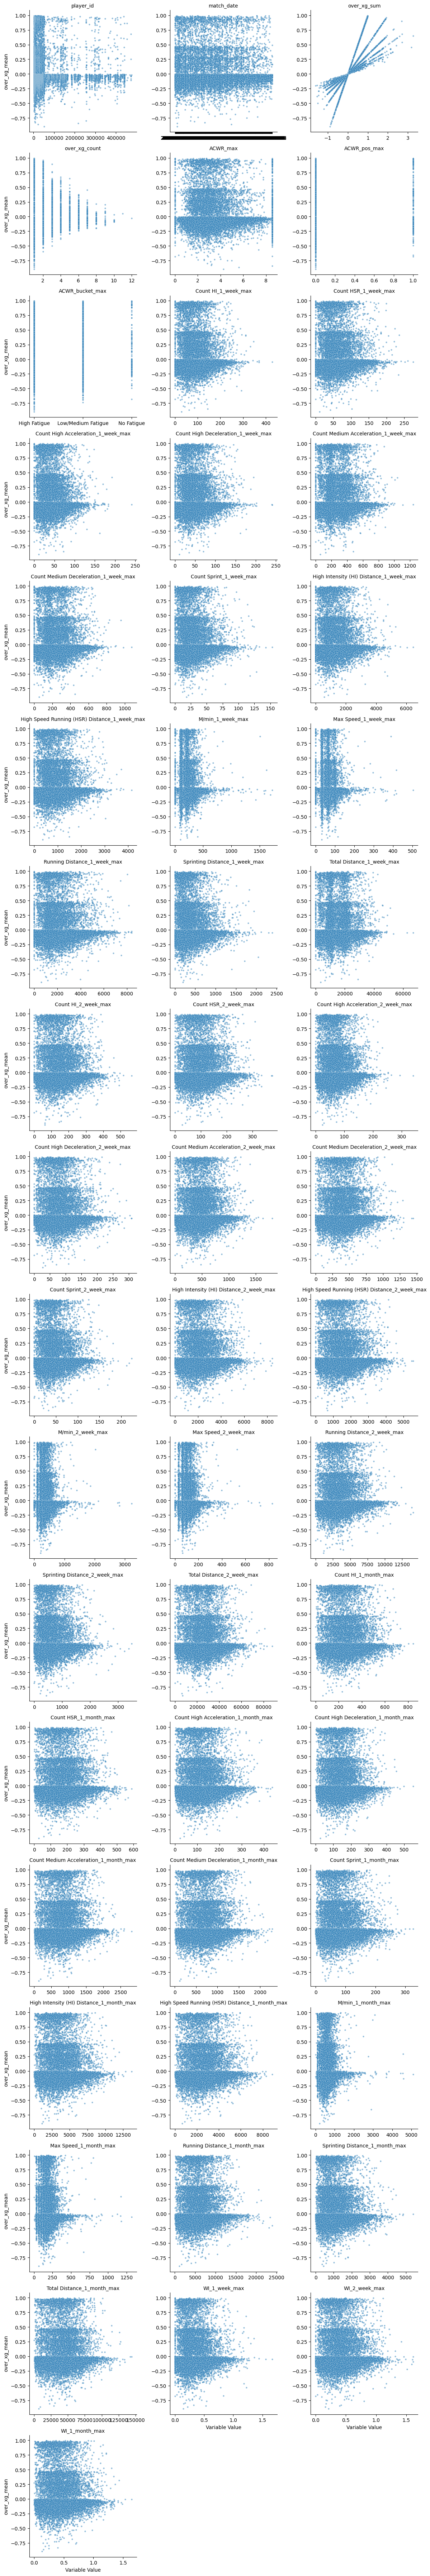

In [53]:
target = "over_xg_mean"

# Select the variables you want to plot against statsbomb_xg_mean
# Exclude the target itself and any other columns you don't want to plot
plot_variables = [col for col in shots_by_player_match.columns 
                  if col != target and col not in ['team_id']]  # player_id, 'player_name'

df_melted = shots_by_player_match.melt(id_vars=[target], 
                                      value_vars=plot_variables,
                                      var_name="variable", 
                                      value_name="x_value")

g = sns.FacetGrid(df_melted, col="variable", col_wrap=3, sharex=False, sharey=False, height=4)
g.map_dataframe(sns.scatterplot, x="x_value", y=target, alpha=0.5, s=10)
g.set_titles(col_template="{col_name}")
g.set_axis_labels(x_var="Variable Value", y_var=target)
plt.tight_layout()
plt.show()

import seaborn as sns
import matplotlib.pyplot as plt

target = "statsbomb_xg_count"
df_melted = shots_by_player_match_good.melt(id_vars=target, var_name="variable", value_name="value")

g = sns.FacetGrid(df_melted, col="variable", col_wrap=3, sharex=False, sharey=False, height=4)
g.map_dataframe(sns.scatterplot, x=target, y="value", alpha=0.5, s=10)
g.set_titles(col_template="{col_name}")
plt.show()


so we have:
looked at individual shots to xg
match level statistics
including just top players

to do:
do tired players exceed / underperform their xg (maybe plot underperformance by tiredness by age) *done* BUCKET AGE?
within games: does it get worse as game goes on (quality/quantity) 
within team, does shot quality get worse as fatigue builds (dont have stats for whole team currently, just shooter) *done*


In [54]:
shot_metrics_df.head(1)

Unnamed: 0                              event_id  event_index  period  \
0           0  24392d1d-314a-4063-a729-7775bc0a2c45        130.0     1.0   

      timestamp  minute  second  possession  duration  obv_for_after  \
0  00:03:04.524     3.0     4.0         9.0  0.471596       0.306241   

   obv_for_before  obv_for_net  obv_against_after  obv_against_before  \
0        0.278243     0.027997           0.007197            0.007197   

   obv_against_net  obv_total_net  under_pressure  type_id type_name  \
0              0.0       0.027997               1     16.0      Shot   

   possession_team_id possession_team_name  play_pattern_id play_pattern_name  \
0                36.0      Manchester City              2.0       From Corner   

   team_id        team_name  location_x  location_y  location_z  \
0     36.0  Manchester City       112.7        39.9        0.22   

                                      related_events  player_id  \
0  67dc6041-d315-4ebb-ac8e-18f3fcd24abc, 7d4f2f91...    23616.0   

     player_name  position_id   position_name  statsbomb_xg  goal  penalty  \
0  Erling Håland         23.0  Center Forward      0.166126   1.0      0.0   

   body_part  opposition_in_triangle   gameId  match_date  Count HI_now  \
0  Left Foot                     1.0  3892755  2023-08-11           1.2   

   Count HI_half  Count HI_game  Count HSR_now  Count HSR_half  \
0            0.0            0.0            1.0             0.0   

   Count HSR_game  Count High Acceleration_now  Count High Acceleration_half  \
0             0.0                          0.2                           0.0   

   Count High Acceleration_game  Count High Deceleration_now  \
0                           0.0                          0.4   

   Count High Deceleration_half  Count High Deceleration_game  \
0                           0.0                           0.0   

   Count Medium Acceleration_now  Count Medium Acceleration_half  \
0                            6.8                             0.0   

   Count Medium Acceleration_game  Count Medium Deceleration_now  \
0                             0.0                            4.4   

   Count Medium Deceleration_half  Count Medium Deceleration_game  \
0                             0.0                             0.0   

   Count Sprint_now  Count Sprint_half  Count Sprint_game  \
0               0.2                0.0                0.0   

   High Intensity (HI) Distance_now  High Intensity (HI) Distance_half  \
0                         17.017352                                0.0   

   High Intensity (HI) Distance_game  High Speed Running (HSR) Distance_now  \
0                                0.0                              15.196193   

   High Speed Running (HSR) Distance_half  \
0                                     0.0   

   High Speed Running (HSR) Distance_game  M/min_now  M/min_half  M/min_game  \
0                                     0.0  20.433466         0.0         0.0   

   Max Speed_now  Max Speed_half  Max Speed_game  Running Distance_now  \
0       5.187833             0.0             0.0             37.352316   

   Running Distance_half  Running Distance_game  Sprinting Distance_now  \
0                    0.0                    0.0                1.821159   

   Sprinting Distance_half  Sprinting Distance_game  Total Distance_now  \
0                      0.0                      0.0          306.501986   

   Total Distance_half  Total Distance_game  Count HI_1_week  \
0                  0.0                  0.0             48.0   

   Count HSR_1_week  Count High Acceleration_1_week  \
0              30.0                            30.0   

   Count High Deceleration_1_week  Count Medium Acceleration_1_week  \
0                            25.0                             141.0   

   Count Medium Deceleration_1_week  Count Sprint_1_week  \
0                             110.0                 18.0   

   High Intensity (HI) Distance_1_week  \
0                        

In [55]:
player_buckets = shot_metrics_df[["player_id","ACWR_bucket","statsbomb_xg"]].groupby(["player_id","ACWR_bucket"],as_index=False).mean()

C:\Users\conny\AppData\Local\Temp\ipykernel_15640\3605242658.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  player_buckets = shot_metrics_df[["player_id","ACWR_bucket","statsbomb_xg"]].groupby(["player_id","ACWR_bucket"],as_index=False).mean()


In [96]:
quantiles = df.groupby('age')['ACWR'].quantile([0.25, 0.5, 0.75])
print(quantiles)

age      
15   0.25    1.909864
     0.50    1.909864
     0.75    2.132180
17   0.25    2.094065
     0.50    2.896189
               ...   
38   0.50    2.890564
     0.75    4.463998
39   0.25    1.757305
     0.50    2.585407
     0.75    3.089427
Name: ACWR, Length: 72, dtype: float64


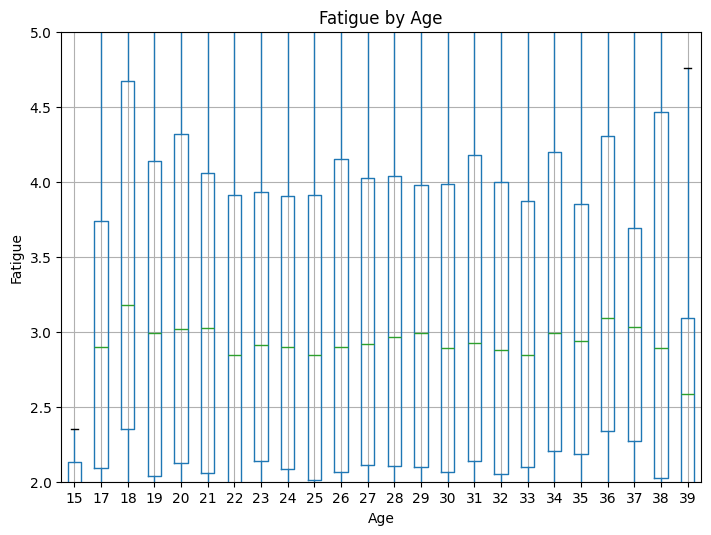

In [83]:
import plotly.express as px
df = shot_metrics_df.copy()
fig, ax = plt.subplots(figsize=(8, 6))
df.boxplot(column="ACWR", by="age", ax=ax)

# Beautify
ax.set_title("Fatigue by Age")
ax.set_xlabel("Age")
ax.set_ylabel("Fatigue")

plt.ylim(2, 5)
plt.suptitle("")  # remove automatic "Boxplot grouped by..." title
plt.show()

In [57]:
player_buckets

player_id         ACWR_bucket  statsbomb_xg
0        2935.0          No Fatigue           NaN
1        2935.0  Low/Medium Fatigue      0.007836
2        2935.0        High Fatigue      0.123927
3        2941.0          No Fatigue           NaN
4        2941.0  Low/Medium Fatigue      0.185844
...         ...                 ...           ...
4849   472259.0  Low/Medium Fatigue      0.109403
4850   472259.0        High Fatigue      0.089437
4851   476247.0          No Fatigue           NaN
4852   476247.0  Low/Medium Fatigue           NaN
4853   476247.0        High Fatigue      0.018165

[4854 rows x 3 columns]

KeyError: 'ACWR_pos'

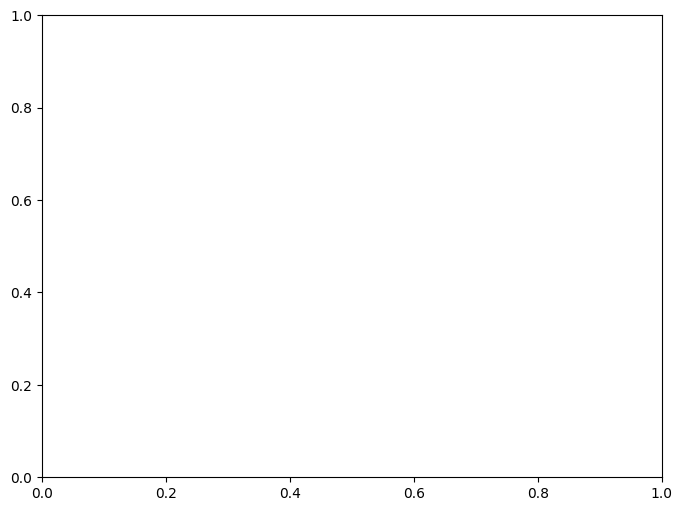

In [58]:
import plotly.express as px
df = player_buckets.copy()
fig, ax = plt.subplots(figsize=(8, 6))
df.boxplot(column="over_xg", by="ACWR_pos", ax=ax)

# Beautify
ax.set_title("xg differential by ACWR bucket")
ax.set_xlabel("ACWR pos")
ax.set_ylabel("xG Differential")
plt.suptitle("")  # remove automatic "Boxplot grouped by..." title
plt.show()

on average a shot in Q1 is 0.06 and a shot in Q4 is 0.007 less likely to go in 

the risk is greater when a player is undercooked

In [59]:
player_buckets = shot_metrics_df[["player_id","ACWR_bucket","statsbomb_xg"]].groupby(["player_id","ACWR_bucket"],as_index=False).mean()

C:\Users\conny\AppData\Local\Temp\ipykernel_15640\3605242658.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  player_buckets = shot_metrics_df[["player_id","ACWR_bucket","statsbomb_xg"]].groupby(["player_id","ACWR_bucket"],as_index=False).mean()


In [60]:
shot_metrics_df["ACWR_bucket"].value_counts()

ACWR_bucket
High Fatigue          34162
Low/Medium Fatigue    14737
No Fatigue              746
Name: count, dtype: int64

In [61]:
df_wide = player_buckets.pivot(index='player_id', columns='ACWR_bucket', values='statsbomb_xg').fillna(0).reset_index()
df_wide.columns.name = None

In [62]:
df_wide.quantile([0,0.25,0.5,0.75,1])

player_id  No Fatigue  Low/Medium Fatigue  High Fatigue
0.00    2935.00    0.000000            0.000000      0.000000
0.25    8354.25    0.000000            0.030089      0.052026
0.50   24020.00    0.000000            0.063294      0.078820
0.75   48530.00    0.000000            0.097455      0.112880
1.00  476247.00    0.723024            0.960144      0.943822

In [63]:
df_wide.mean()#use?

player_id             63394.872064
No Fatigue                0.018004
Low/Medium Fatigue        0.071051
High Fatigue              0.088150
dtype: float64

In [64]:
player_buckets = shot_metrics_df[["player_id","ACWR_bucket","over_xg"]].groupby(["player_id","ACWR_bucket"],as_index=False).mean()
df_wide = player_buckets.pivot(index='player_id', columns='ACWR_bucket', values='over_xg').fillna(0).reset_index()
df_wide.columns.name = None

C:\Users\conny\AppData\Local\Temp\ipykernel_15640\3048449089.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  player_buckets = shot_metrics_df[["player_id","ACWR_bucket","over_xg"]].groupby(["player_id","ACWR_bucket"],as_index=False).mean()


In [65]:
df_wide.quantile([0,0.25,0.5,0.75,1])

player_id  No Fatigue  Low/Medium Fatigue  High Fatigue
0.00    2935.00   -0.420370           -0.452362     -0.583569
0.25    8354.25    0.000000           -0.054835     -0.053953
0.50   24020.00    0.000000           -0.015177     -0.019008
0.75   48530.00    0.000000            0.013242      0.028687
1.00  476247.00    0.992851            0.937357      0.966884

In [66]:
df_wide.mean()

player_id             63394.872064
No Fatigue                0.002328
Low/Medium Fatigue       -0.001697
High Fatigue             -0.004975
dtype: float64

In [67]:
player_buckets = shot_metrics_df[["player_id","ACWR_bucket","statsbomb_xg"]].groupby(["player_id","ACWR_bucket"],as_index=False).count()
df_wide = player_buckets.pivot(index='player_id', columns='ACWR_bucket', values='statsbomb_xg').fillna(0).reset_index()
df_wide.columns.name = None
df_wide.quantile([0,0.25,0.5,0.75,1])

C:\Users\conny\AppData\Local\Temp\ipykernel_15640\3985613605.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  player_buckets = shot_metrics_df[["player_id","ACWR_bucket","statsbomb_xg"]].groupby(["player_id","ACWR_bucket"],as_index=False).count()


player_id  No Fatigue  Low/Medium Fatigue  High Fatigue
0.00    2935.00         0.0                 0.0           0.0
0.25    8354.25         0.0                 1.0           5.0
0.50   24020.00         0.0                 5.0          12.0
0.75   48530.00         0.0                12.0          26.0
1.00  476247.00        30.0                89.0         231.0

In [68]:
print(player_buckets["ACWR_bucket"].value_counts(normalize=True))

ACWR_bucket
No Fatigue            0.333333
Low/Medium Fatigue    0.333333
High Fatigue          0.333333
Name: proportion, dtype: float64


In [69]:
df_wide.mean()

player_id             63394.872064
No Fatigue                0.461063
Low/Medium Fatigue        9.108158
High Fatigue             21.113721
dtype: float64

In [70]:
player_buckets = shot_metrics_df[["player_id","ACWR","statsbomb_xg"]].groupby(["player_id","ACWR"],as_index=False).mean()
df_wide = player_buckets.pivot(index='player_id', columns='ACWR', values='statsbomb_xg').fillna(0).reset_index()
df_wide.columns.name = None


<Axes: xlabel='statsbomb_xg', ylabel='ACWR'>

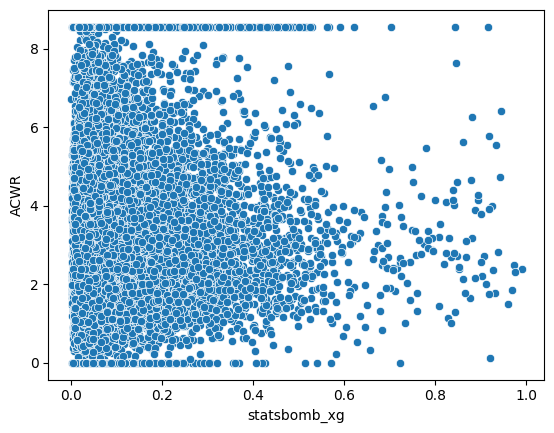

In [71]:

sns.scatterplot(data=player_buckets, x="statsbomb_xg", y="ACWR")

In [72]:
player_buckets = shot_metrics_df[["player_id","ACWR_bucket","statsbomb_xg"]].groupby(["player_id","ACWR_bucket"],as_index=False).mean()
df_wide = player_buckets.pivot(index='player_id', columns='ACWR_bucket', values='statsbomb_xg').fillna(0).reset_index()
df_wide.columns.name = None
df_wide.quantile([0,0.25,0.5,0.75,1])

C:\Users\conny\AppData\Local\Temp\ipykernel_15640\91589385.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  player_buckets = shot_metrics_df[["player_id","ACWR_bucket","statsbomb_xg"]].groupby(["player_id","ACWR_bucket"],as_index=False).mean()


player_id  No Fatigue  Low/Medium Fatigue  High Fatigue
0.00    2935.00    0.000000            0.000000      0.000000
0.25    8354.25    0.000000            0.030089      0.052026
0.50   24020.00    0.000000            0.063294      0.078820
0.75   48530.00    0.000000            0.097455      0.112880
1.00  476247.00    0.723024            0.960144      0.943822

In [73]:
team_metrics_df= shot_metrics_df[["match_date","player_id","ACWR","statsbomb_xg"]].groupby(["match_date","player_id"],as_index=False).mean()

In [74]:
team_metrics_df['match_date'] = pd.to_datetime(team_metrics_df['match_date'])
team_metrics_df['week_start'] = team_metrics_df['match_date'].dt.to_period('W').dt.start_time

group_col = ["week_start", "player_id"]
mean_col = "statsbomb_xg"  # using your actual column name from earlier
other_cols = ["ACWR"]

agg_dict = {mean_col: 'first'}  # take the first xg value for the week
agg_dict.update({col: 'mean' for col in other_cols})

team_agg_df = team_metrics_df.groupby(group_col, as_index=False).agg(agg_dict)

print(team_agg_df.head())
print(f"Original rows: {len(team_metrics_df)}")
print(f"Weekly aggregated rows: {len(team_agg_df)}")

  week_start  player_id  statsbomb_xg     ACWR
0 2023-08-07     3074.0      0.125045  8.55778
1 2023-08-07     3083.0      0.121870  8.55778
2 2023-08-07     3088.0      0.052234  8.55778
3 2023-08-07     3089.0      0.023693  8.55778
4 2023-08-07     3097.0      0.151170  8.55778
Original rows: 26956
Weekly aggregated rows: 24651


In [75]:
team_agg_df.to_csv("shooter_dlnm.csv")